<a href="https://colab.research.google.com/github/CharlemagneBrain/Transfer_Learning/blob/main/Transfer_Learning_FE_FT_SU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Première partie**: Extraction de caractéristiques ⚒

=> Consiste à prendre les poids sous jacents qu'un modèle préentrainé a appris et à ajuster ses sorties pour qu'elles plus adaptées à notre problème.

### Téléchargeons nos données 

In [1]:
import zipfile
import os

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-01-04 15:34:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   176MB/s    in 0.9s    

2023-01-04 15:34:56 (176 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



### Combien d'images par dossiers avons nous ?

In [2]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent/"):
  print(f"Il y a {len(dirnames)} dossiers et {len(filenames)} images dans {dirpath} ")

Il y a 2 dossiers et 0 images dans 10_food_classes_10_percent/ 
Il y a 10 dossiers et 0 images dans 10_food_classes_10_percent/train 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/fried_rice 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/hamburger 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/ice_cream 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/chicken_curry 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/sushi 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/chicken_wings 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/ramen 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/grilled_salmon 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/pizza 
Il y a 0 dossiers et 75 images dans 10_food_classes_10_percent/train/steak 
Il y a 10 dossiers et 0 images dans 10_food_classes_10_percent/test 

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Le paramètre rescale, ainsi que 1/255, revient à dire "divisez toutes les valeurs des pixels par 255". 
Ainsi, toutes les images sont importées et leurs valeurs de pixels sont normalisées (converties pour être comprises entre 0 et 1).

In [4]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Entrainement:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Test:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Entrainement:
Found 750 images belonging to 10 classes.
Test:
Found 2500 images belonging to 10 classes.


### Création d'un callback TensorBoard

Les callbacks 🆕 sont des fonctionnalités supplémentaires que l'on peut ajouter à vos modèles et qui seront exécutées pendant ou après la formation. Voici quelques-uns des callbacks les plus populaires :

- ⛓ Suivi des expériences avec TensorBoard (Experiment tracking with TensorBoard):  enregistrer les performances de plusieurs modèles, puis visualiser et comparer ces modèles de manière visuelle sur TensorBoard (un tableau de bord pour inspecter les paramètres des réseaux neuronaux). Utile pour comparer les résultats de différents modèles sur vos données.

- 🎛 Point de contrôle du modèle(Model checkpointing) : enregistrer notre modèle au fur et à mesure qu'il s'entraîne afin de pouvoir interrompre l'entraînement si nécessaire et revenir pour reprendre là où nous en étions. Utile si la formation prend beaucoup de temps et ne peut pas être effectuée en une seule séance.

- 🛑 Arrêt anticipé (Early stopping) :  laisser notre modèle s'entraîner pendant une durée arbitraire et faire en sorte qu'il s'arrête automatiquement lorsqu'il ne s'améliore plus. Cette option est utile lorsque nous disposons d'un grand ensemble de données et que nous ne savons pas combien de temps la formation prendra.

On peut accéder à la fonction de rappel TensorBoard en utilisant `tf.keras.callbacks.TensorBoard()`.

Sa principale fonctionnalité est l'enregistrement des mesures de performance de la formation d'un modèle dans un répertoire log_dir spécifié.

💡 Par défaut, les journaux sont enregistrés toutes les époques en utilisant le paramètre `update_freq='epoch'`. Il s'agit d'une bonne valeur par défaut, car le suivi des performances du modèle trop souvent peut ralentir la formation du modèle.


🔑 Remarque : nous créons une fonction pour créer une callback TensorBoard car, comme nous le verrons plus tard, chaque modèle a besoin de sa propre instance de callback TensorBoard (la fonction en créera donc une nouvelle à chaque exécution).



dirname = répertoire général des journaux
experiment_name = nom de l'expérience 

Par exemple, si dirname est "logs" et experiment_name est "exp1", log_dir pourrait être "logs/exp1/20210301-124532".

In [5]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Sauvegarde fichiers log dans: {log_dir}")
  return tensorboard_callback

### Création de model avec Tensorflow Hub

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

Prend une URL de Hub TensorFlow et crée un modèle Keras Sequential avec celle-ci.
  
  Arguments :
    model_url (str) : Une URL d'extraction de caractéristiques de TensorFlow Hub.
    num_classes (int) : Nombre de neurones de sortie dans la couche de sortie,
      doit être égal au nombre de classes cibles, par défaut 10.

  Retourne :
    Un modèle séquentiel Keras non compilé, avec model_url comme couche
    extracteur de caractéristiques et une couche de sortie dense avec des sorties num_classes.

In [7]:

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
def create_model(model_url, num_classes=10):
  
  # Modèle prétrainé
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, 
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) 
  
  # Creation de notre propre modèle
  model = tf.keras.Sequential([
    feature_extractor_layer, 
    layers.Dense(num_classes, activation='softmax', name='output_layer') # creation de notre propre couche     
  ])

  return model

In [9]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)


resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [10]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Sauvegarde fichiers log dans: tensorflow_hub/resnet50V2/20230104-153511
Epoch 1/5
24/24 [==============================] - 30s 764ms/step - loss: 1.7445 - accuracy: 0.3973 - val_loss: 1.0957 - val_accuracy: 0.6672
Epoch 2/5
24/24 [==============================] - 16s 692ms/step - loss: 0.8403 - accuracy: 0.7373 - val_loss: 0.8303 - val_accuracy: 0.7360
Epoch 3/5
24/24 [==============================] - 17s 728ms/step - loss: 0.5891 - accuracy: 0.8347 - val_loss: 0.7276 - val_accuracy: 0.7616
Epoch 4/5
24/24 [==============================] - 24s 1s/step - loss: 0.4485 - accuracy: 0.8787 - val_loss: 0.6922 - val_accuracy: 0.7700
Epoch 5/5
24/24 [==============================] - 16s 685ms/step - loss: 0.3613 - accuracy: 0.9213 - val_loss: 0.6614 - val_accuracy: 0.7848


In [11]:
import matplotlib.pyplot as plt


def plot_loss_curves(history):
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  
  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Perte')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Précision')
  plt.xlabel('Epochs')
  plt.legend();


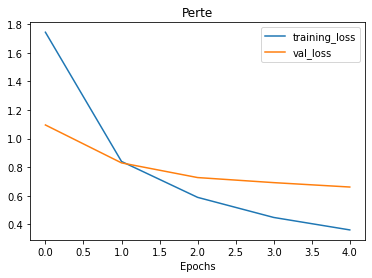

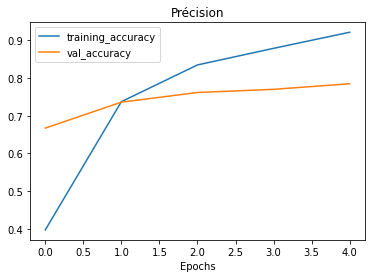

In [12]:
plot_loss_curves(resnet_history)

In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


Faisons de même pour le modèle EfficientNet

In [14]:
efficientnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

efficientnet_history = efficientnet_model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="efficientnetB0")]
)

Sauvegarde fichiers log dans: tensorflow_hub/efficientnetB0/20230104-153704
Epoch 1/5
24/24 [==============================] - 25s 722ms/step - loss: 1.8507 - accuracy: 0.4400 - val_loss: 1.3035 - val_accuracy: 0.7248
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 1.0667 - accuracy: 0.7653 - val_loss: 0.8681 - val_accuracy: 0.8244
Epoch 3/5
24/24 [==============================] - 15s 651ms/step - loss: 0.7659 - accuracy: 0.8333 - val_loss: 0.7002 - val_accuracy: 0.8460
Epoch 4/5
24/24 [==============================] - 15s 660ms/step - loss: 0.6131 - accuracy: 0.8667 - val_loss: 0.6108 - val_accuracy: 0.8568
Epoch 5/5
24/24 [==============================] - 15s 658ms/step - loss: 0.5219 - accuracy: 0.8773 - val_loss: 0.5575 - val_accuracy: 0.8628


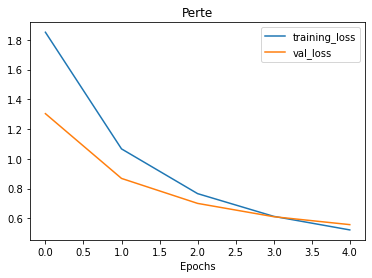

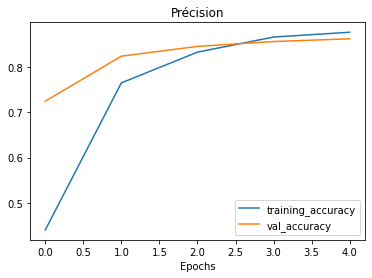

In [15]:
plot_loss_curves(efficientnet_history)

D'après les courbes de perte du modèle EfficientNetB0, il semble que si nous continuions à entraîner notre modèle plus longtemps, il pourrait s'améliorer encore plus.

In [16]:
# Regardons le résumé
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________



## Comparaison des modèles à l'aide de TensorBoard

Le téléchargement des résultats sur TensorBoard.dev permet de suivre et de partager plusieurs expériences de modélisation différentes. Ainsi, si on doit montrer les résultats à quelqu'un, on peut lui envoyer un lien vers notre TensorBoard.dev ainsi que le cahier Colab qui l'accompagne.

### Téléchargement d'expériences vers TensorBoard
Pour télécharger une série de journaux TensorFlow vers TensorBoard, nous pouvons utiliser la commande suivante :

Télécharger les enregistrements de TensorBoard dev
```python
  !tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientNetB0 vs. ResNet50V2" \ 
    --description "Comparaison de deux architectures différentes de modèles d'extraction de caractéristiques du Hub TF en utilisant 10% des images d'entraînement" \ 
    --une_image
```
Où :

- logdir est le répertoire de téléchargement cible
- name est le nom de l'expérience
- description est une brève description de l'expérience
- one_shot quitte l'uploader TensorBoard une fois le téléchargement terminé.



In [17]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparaison de deux architectures différentes de modèles d'extraction de caractéristiques du Hub TF en utilisant 10% des images d'entraînement" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=kyctPA7qyooBEm1luyOR2jXOQ6vrG0&prompt=consent&access_type=off

In [18]:
!tensorboard dev list

https://tensorboard.dev/experiment/b5HyBf1PQwGWJDTmvwOvfw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparaison de deux architectures différentes de modèles d'extraction de caractéristiques du Hub TF en utilisant 10% des images d'entraînement
	Id                   b5HyBf1PQwGWJDTmvwOvfw
	Created              2023-01-04 15:46:45 (6 seconds ago)
	Updated              2023-01-04 15:46:47 (just now)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918466
https://tensorboard.dev/experiment/xIdbkq1YSJGI5bQJnKKI3g/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparaison de deux architectures différentes de modèles d'extraction de caractéristiques du Hub TF en utilisant 10% des images d'entraînement
	Id                   xIdbkq1YSJGI5bQJnKKI3g
	Created              2023-01-03 20:21:46 (19 hours ago)
	Updated              2023-01-03 20:21:48 (19 hours ago)
	Runs 

## **Deuxième Partie :** Ajustement Fin

=> Consiste à prendre les poids du modèle préentrainé et de les adapter au problème . Cela signifie généralement l'entrainement de nombreuses ou de toutes les couches du modèle préentrainé. D'où il est utile lorsqu'on dispose d'un grand ensemble de données et ces dernières sont légèrement différentes de celles sur lesquelles le modèle préentrainé a été formé. <br/>

**NB** : ***Transfer Learning par extraction de caractéristiques vs Transfer Learning par réglage fin***: <br/>
La principale différence entre les deux est qu'en cas d'ajustement fin, davantage de couches du modèle pré-entraîné sont dégelées et ajustées sur des données personnalisées. Ce réglage fin nécessite généralement plus de données que l'extraction de caractéristiques pour être efficace.



